# Rubik's Cube Solver using Graph Theory and A* Search

- This notebook implements a simplified 3x3 Rubik's Cube solver. 
- It demonstrates how to represent the cube in code, apply moves, scramble it, and solve it using A* search guided by a basic heuristic. 
- Visualizations of the cube states before and after solving are also included.

---

## Libraries
- `pip install networkx matplotlib` to install libraries

In [50]:
import copy
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import heapq

## Constants and Move Mapping

In [51]:
# Define Rubik's Cube faces and colors
colors = ['W', 'Y', 'G', 'B', 'O', 'R']  # White, Yellow, Green, Blue, Orange, Red
faces = ['U', 'D', 'F', 'B', 'L', 'R'] # Up, Down, Front, Back, Left, Right


# Mapping each face rotation to the adjacent faces and corresponding edges that are affected
move_map = {
    'U': [('B', 0), ('R', 0), ('F', 0), ('L', 0)],
    'D': [('F', 2), ('R', 2), ('B', 2), ('L', 2)],
    'F': [('U', 2), ('R', 'col0'), ('D', 0), ('L', 'col2')],
    'B': [('U', 0), ('L', 'col0'), ('D', 2), ('R', 'col2')],
    'L': [('U', 'col0'), ('F', 'col0'), ('D', 'col0'), ('B', 'col2')],
    'R': [('U', 'col2'), ('B', 'col0'), ('D', 'col2'), ('F', 'col2')]
}

## Cube Creation and Rotation Helpers

In [52]:
# Creates a solved Rubik's cube with each face having the same color
def create_solved_cube():
    return {face: [[color]*3 for _ in range(3)] for face, color in zip(faces, colors)}

# Rotates a 3x3 face 90 degrees clockwise
def rotate_face_cw(face):
    return [list(row) for row in zip(*face[::-1])]

# Rotates a 3x3 face 90 degrees counter-clockwise
def rotate_face_ccw(face):
    return [list(row) for row in zip(*face)][::-1]

## Row and Column Getters and Setters

In [53]:
# Returns a specific row from a face
def get_row(face, idx):
    return face[idx][:]

# Sets a specific row on a face
def set_row(face, idx, row):
    face[idx] = row[:]

# Returns a specific column from a face
def get_col(face, idx):
    return [row[idx] for row in face]

# Sets a specific column on a face
def set_col(face, idx, col):
    for i in range(3):
        face[i][idx] = col[i]

## Move Application

In [54]:
# Applies a single move to the cube (e.g., 'U', 'U'', 'R', etc.)
def apply_move(cube, move):
    face = move[0]
    direction = 1 if len(move) == 1 else -1  # 1 = clockwise, -1 = counter-clockwise

    # Rotate the face itself
    cube[face] = rotate_face_cw(cube[face]) if direction == 1 else rotate_face_ccw(cube[face])

    # Determine the affected edges
    adj = move_map[face]
    if direction == -1:
        adj = adj[::-1]

    # Extract the edges from adjacent faces
    edges = []
    for side, idx in adj:
        if isinstance(idx, int):  # It's a row
            edges.append(get_row(cube[side], idx))
        else:  # It's a column
            col_idx = int(idx[-1])
            edges.append(get_col(cube[side], col_idx))

    # Rotate the edges (shifted by one)
    edges = [edges[-1]] + edges[:-1]

    # Place the rotated edges back
    for (side, idx), edge in zip(adj, edges):
        if isinstance(idx, int):
            set_row(cube[side], idx, edge)
        else:
            col_idx = int(idx[-1])
            set_col(cube[side], col_idx, edge)

## Scramble Generator

In [55]:
# Applies a series of random moves to scramble the cube
def random_scramble(cube, moves=10):
    move_list = ['U', "U'", 'D', "D'", 'F', "F'", 'B', "B'", 'L', "L'", 'R', "R'"]
    scramble_seq = random.choices(move_list, k=moves)
    states = [copy.deepcopy(cube)]
    for move in scramble_seq:
        new_state = copy.deepcopy(states[-1])
        apply_move(new_state, move)
        states.append(new_state)
    return states, scramble_seq

## State Visualizer

In [56]:
# Draws the cube in a 2D layout using matplotlib
def visualize_cube_state(cube, title='Cube State', ax=None):
    # Layout positions for each face on a 2D grid
    face_coords = {
        'U': (3, 6), 'L': (0, 3), 'F': (3, 3),
        'R': (6, 3), 'B': (9, 3), 'D': (3, 0)
    }
    color_lookup = {
        'W': 'lightgray', # Used gray instead of white to better identify
        'Y': 'yellow',
        'G': 'green',
        'B': 'blue',
        'O': 'orange',
        'R': 'red'
    }
    if ax is None:
        fig, ax = plt.subplots()
    ax.clear()

    # Draw each square of the cube face
    for face, (x_offset, y_offset) in face_coords.items():
        face_grid = cube[face]
        for i in range(3):
            for j in range(3):
                color = color_lookup[face_grid[i][j]]
                ax.add_patch(plt.Rectangle(
                    (x_offset + j, y_offset + 2 - i), 1, 1, facecolor=color))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.axis('off')

## Animation

In [57]:
# Animates a list of cube states as a solution is applied
def animate_solution(states, title='Solving Cube'):
    fig, ax = plt.subplots()

    def update(frame):
        visualize_cube_state(states[frame], title=f'{title}: Step {frame}', ax=ax)

    ani = animation.FuncAnimation(
        fig, update, frames=len(states), repeat=False, interval=500)
    plt.show()

## Utility Functions

In [ ]:
# Checks if the cube is in a solved state
def is_solved(cube):
    for face in cube:
        center = cube[face][1][1]
        for row in cube[face]:
            for color in row:
                if color != center:
                    return False
    return True

# Heuristic function for A* search — counts how many stickers are not the same as the center color of their face
def heuristic(cube):
    score = 0
    for face in cube:
        center = cube[face][1][1]
        for row in cube[face]:
            for color in row:
                if color != center:
                    score += 1
    return score

# Applies a sequence of moves to the cube and returns all intermediate states
def apply_sequence(cube, sequence):
    states = [copy.deepcopy(cube)]
    for move in sequence:
        apply_move(cube, move)
        states.append(copy.deepcopy(cube))
    return states


## A* Search Algorithm

In [ ]:
# Solves the scrambled cube using A* search
def a_star_solver(start_cube):
    move_list = ['U', "U'", 'D', "D'", 'F', "F'", 'B', "B'", 'L', "L'", 'R', "R'"]
    visited = set()
    queue = []
    counter = 0

    # Push initial state into priority queue (min-heap): (estimated_total_cost, current_cost, counter, cube, path)
    heapq.heappush(queue, (0, 0, counter, start_cube, []))

    while queue:
        _, cost, _, current, path = heapq.heappop(queue)
        cube_id = str(current)  # Serialize cube for visited set

        if cube_id in visited:
            continue
        visited.add(cube_id)

        if is_solved(current):
            return path  # Return the solution path

        for move in move_list:
            new_cube = copy.deepcopy(current)
            apply_move(new_cube, move)
            if str(new_cube) not in visited:
                new_path = path + [move]
                est_cost = cost + 1 + heuristic(new_cube)
                counter += 1
                heapq.heappush(queue, (est_cost, cost + 1, counter, new_cube, new_path))
    return []

In [ ]:
def a_star_solver(start_cube):
    move_list = ['U', "U'", 'D', "D'", 'F', "F'", 'B', "B'", 'L', "L'", 'R', "R'"]
    visited = set()
    queue = []
    counter = 0
    heapq.heappush(queue, (0, 0, counter, start_cube, []))

    while queue:
        _, cost, _, current, path = heapq.heappop(queue)
        cube_id = str(current)
        
        # Print the cost of the current move
        print(f"Current state cost: {cost} (Move count so far)")

        if cube_id in visited:
            continue
        visited.add(cube_id)
        
        # Check if the goal state (solved) is reached
        if is_solved(current):
            print(f"Goal reached with path: {path}")
            return path
        
        # Explore all possible moves
        for move in move_list:
            new_cube = copy.deepcopy(current)
            apply_move(new_cube, move)
            
            if str(new_cube) not in visited:
                new_path = path + [move]
                est_cost = cost + 1 + heuristic(new_cube)
                counter += 1
                # Print the move and its resulting cost
                print(f"Applying move: {move}")
                print(f"New cost after move: {cost + 1}")
                heapq.heappush(queue, (est_cost, cost + 1, counter, new_cube, new_path))
                
    return []

## Main Execution

Scramble sequence: ["L'", "D'", 'U', "B'", 'U']
Solution sequence: ["U'", 'B', "U'", 'D', 'L']


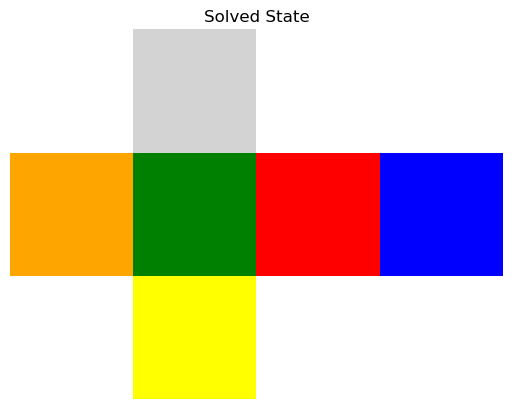

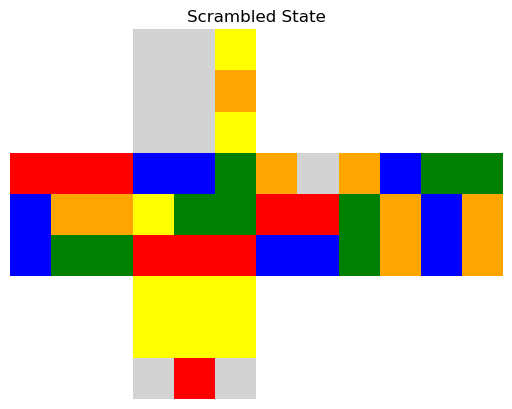

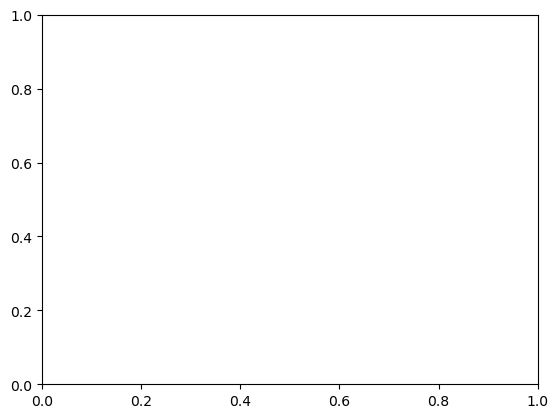

In [60]:
# Initialize the cube / start with the solved state
cube = create_solved_cube()

# Scramble the cube randomly
states, scramble_seq = random_scramble(cube, moves=5)
scrambled = copy.deepcopy(states[-1])
print("Scramble sequence:", scramble_seq)

# Visualize both states
visualize_cube_state(states[0], title='Solved State') # Shows the initial solved cube
visualize_cube_state(scrambled, title='Scrambled State') # Shows the scrambled state

# Solve the scrambled cube using A* algorithm
solution_seq = a_star_solver(copy.deepcopy(scrambled))
print("Solution sequence:", solution_seq)

# Apply the solution sequence to the scrambled cube to generate the solving steps
solve_states = apply_sequence(scrambled, solution_seq)

# Animate the solving process, step-by-step
animate_solution(solve_states, title='Solving with A* Search')


---
## Overview: How Graph Theory is Used in the Rubik's Cube Solver

### 1. Cube States as Graph Nodes

Each **unique configuration** of the Rubik's Cube is treated as a **node (vertex)** in a graph.

- A solved cube is one node.
- A scrambled cube is another.
- Any configuration reachable via legal moves is another node.

**The entire state space of the Rubik's Cube forms a large directed graph:**
- **Nodes** = cube configurations (states)
- **Edges** = legal moves (e.g., `U`, `F'`, `R`)

### 2. Moves as Directed Edges

Each **legal move** on the cube (e.g., rotating the front face clockwise) is considered a **directed edge** from one state to another.

- For example: applying "F" to state A results in state B  
  → this creates a **directed edge A → B labeled "F"**.

Since some moves may not return to the exact previous state (without explicit reversal), this graph is **directed**.

### 3. A* Search as Graph Traversal

The **A\* search algorithm** is a classic **graph traversal** technique that finds the **shortest path** from a scrambled cube to the solved state.

- Uses actual cost `g(n)` = number of moves so far.
- Uses heuristic `h(n)` = estimated cost to goal (based on misplaced stickers).
- Evaluates nodes by `f(n) = g(n) + h(n)` using a **priority queue (heap)**.

It efficiently searches through the Rubik’s cube’s **state-space graph**.

### 4. Optional Visualization with NetworkX

The function `build_state_graph()` (optional) uses **NetworkX** to explicitly construct a directed graph:

- Each node = a state of the cube.
- Each edge = a move between states.
- This is useful for **visualizing** the scrambling or solving path, not necessary for solving.

### Summary Table

| Graph Theory Concept | Rubik's Cube Equivalent             |
|----------------------|-------------------------------------|
| Node                 | A cube state (configuration)        |
| Edge                 | A move (e.g., U, R', F)             |
| Path                 | A sequence of moves                 |
| Goal Node            | The solved cube state               |
| Search Algorithm     | A* (shortest path finder)           |